In [1]:
import torch
import gpytorch
from gpytorch_utils.gp_model import ExactGPModel
import matplotlib.pyplot as plt
import numpy as np
from gpytorch_utils.gp_hyperparam_training import train_gp_model
import copy

In [2]:
# evaluate g = -c*\dot{x}^2
def eval_g(xdot, c):
    return -c*xdot**2


# generate values of Y_out = g(\dot{x}) for a collection of inputs X_inp = \dot{x}
# specific for the g being a scalar function
def generate_g_outputs(x_train, c, noise_size):

    n_train = x_train.shape[0]
    y_train = torch.zeros(n_train)

    for i in range(0,n_train):
        g_value = eval_g(x_train[i],c)
        noise_value = (torch.rand(1)-0.5)*noise_size
        y_train[i] = g_value + noise_value

    return y_train


torch.manual_seed(0)
c = 0.1
start_x_offline = 0
stop_x_offline = 1.2
n_offline_data = 4
x_train_offline = torch.linspace(start_x_offline, stop_x_offline, n_offline_data)
x_train_offline = torch.tensor([0.0,0.1,0.2,0.25,0.4,1.0,1.3,1.45,1.5])
# x_train_offline = torch.cat((x_train_offline,torch.tensor([2.0])))
n_offline_data = x_train_offline.shape[0]
noise_size = 0.05
y_train_offline = generate_g_outputs(x_train_offline, c, noise_size)

In [3]:
X_train = x_train_offline.unsqueeze(1)  # shape: (n_data,1)
Y_train = y_train_offline               # shape: (n_data)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = ExactGPModel(X_train, Y_train, likelihood)

training_iterations = 100
rng_seed = 456

gp_model, likelihood = train_gp_model(gp_model, torch_seed=rng_seed, training_iterations=training_iterations)

# EVAL MODE
gp_model.eval()
likelihood.eval()

Iter 1/100 - Loss: 1.218
Iter 2/100 - Loss: 1.179
Iter 3/100 - Loss: 1.141
Iter 4/100 - Loss: 1.101
Iter 5/100 - Loss: 1.060
Iter 6/100 - Loss: 1.019
Iter 7/100 - Loss: 0.978
Iter 8/100 - Loss: 0.935
Iter 9/100 - Loss: 0.892
Iter 10/100 - Loss: 0.848
Iter 11/100 - Loss: 0.804
Iter 12/100 - Loss: 0.759
Iter 13/100 - Loss: 0.714
Iter 14/100 - Loss: 0.668
Iter 15/100 - Loss: 0.622
Iter 16/100 - Loss: 0.575
Iter 17/100 - Loss: 0.528
Iter 18/100 - Loss: 0.481
Iter 19/100 - Loss: 0.433
Iter 20/100 - Loss: 0.386
Iter 21/100 - Loss: 0.337
Iter 22/100 - Loss: 0.289
Iter 23/100 - Loss: 0.241
Iter 24/100 - Loss: 0.192
Iter 25/100 - Loss: 0.144
Iter 26/100 - Loss: 0.095
Iter 27/100 - Loss: 0.047
Iter 28/100 - Loss: -0.001
Iter 29/100 - Loss: -0.050
Iter 30/100 - Loss: -0.098
Iter 31/100 - Loss: -0.145
Iter 32/100 - Loss: -0.193
Iter 33/100 - Loss: -0.240
Iter 34/100 - Loss: -0.286
Iter 35/100 - Loss: -0.332
Iter 36/100 - Loss: -0.377
Iter 37/100 - Loss: -0.422
Iter 38/100 - Loss: -0.466
Iter 39/10

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [4]:
x_new = torch.tensor([2.0])
Y_new = generate_g_outputs(x_new,c,noise_size)
X_new = x_new.unsqueeze(1)
X_train_2 = torch.cat((X_train, X_new))
Y_train_2 = torch.cat((Y_train, Y_new))
gp_model_2 = copy.deepcopy(gp_model)
gp_model_2.set_train_data(X_train_2, Y_train_2, strict=False)

# Note: we do not update the hyperparameter with set_train_data:
for param_name, param in gp_model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.item()}')
for param_name, param in gp_model_2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = -8.789510726928711
Parameter name: mean_module.raw_constant                   value = -0.1272481083869934
Parameter name: covar_module.raw_outputscale               value = -4.186787128448486
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.5765703916549683
Parameter name: likelihood.noise_covar.raw_noise           value = -8.789510726928711
Parameter name: mean_module.raw_constant                   value = -0.1272481083869934
Parameter name: covar_module.raw_outputscale               value = -4.186787128448486
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.5765703916549683


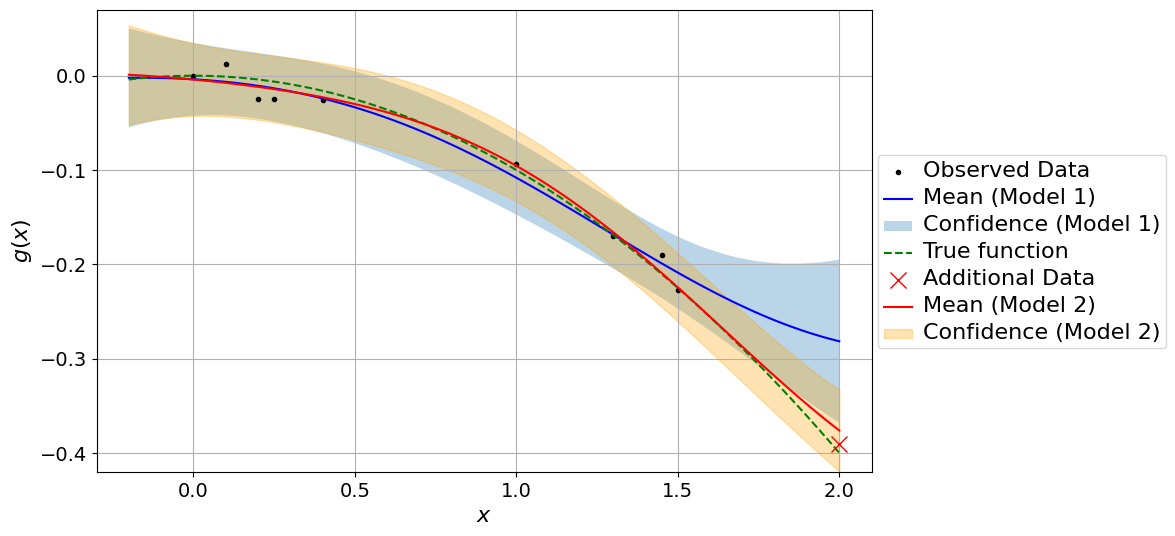

In [25]:
beta = 10.0
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-0.2, 2, 100)
    observed_pred = likelihood(gp_model(test_x))

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-0.2, 2, 100)
    observed_pred_2 = likelihood(gp_model_2(test_x))

true_function_eval = np.zeros(test_x.shape[0])
for i in range(test_x.shape[0]):
    true_function_eval[i] = -c*test_x[i].numpy()**2

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 6))  # update: (7,6), long: (10,6)
    ax.grid()
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train_offline.numpy(), y_train_offline.numpy(), 'k.')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)

    # Plot true function
    ax.plot(test_x.numpy(),true_function_eval,'g--')

    # Plot additional data point
    x_train_2_np = X_train_2.numpy()
    y_train_2_np = Y_train_2.numpy()
    ax.plot(x_train_2_np[-1], y_train_2_np[-1], 'rx',markersize=12)

    # Plotting for gp_model_2
    lower_2, upper_2 = observed_pred_2.confidence_region()
    ax.plot(test_x.numpy(), observed_pred_2.mean.numpy(), 'r')
    ax.fill_between(test_x.numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.3, color='orange')

    # Axis label
    ax.set_xlabel(r'$x$', fontsize=16)
    ax.set_ylabel(r'$g(x)$', fontsize=16)

    # ax.set_ylim([-0.05, 0.05])
    # legend = ax.legend(['Observed Data', 'Mean (Model 1)', 'Confidence (Model 1)','True function $g(x)$'],loc='upper left', bbox_to_anchor=(1, 0.7))
    # legend = ax.legend(['Observed Data', 'Mean (Model 1)', 'Confidence (Model 1)','True function $g(x)$', 'Additional Data'],loc='upper left', bbox_to_anchor=(1, 0.7))
    legend = ax.legend(['Observed Data', 'Mean (Model 1)', 'Confidence (Model 1)','True function','Additional Data', 'Mean (Model 2)', 'Confidence (Model 2)'],loc='upper left', bbox_to_anchor=(1, 0.7))
    for item in legend.get_texts():
        item.set_fontsize(16)

    ax.tick_params(axis='both', which='major', labelsize=14)

    # Plot vertical line
    # plt.axvline(x=0.8,color='k',linewidth=2)

    plt.xlim(-0.3,2.10)
    plt.ylim(-0.42,0.07)
    plt.savefig('gp_update_long.pdf', bbox_inches='tight')
    # ax.legend(['Observed Data', 'Mean', 'Confidence', 'True function'])


    